In [35]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy.io as sio
import scipy.optimize as opt

![Alt text](static/img/anomaly_detection_alg.png )

In [36]:
def estimateGaussian(X):
    """
    This function estimates the parameters of a Gaussian distribution
    using a provided dataset.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n) with each n-dimensional 
        data point in one row, and each total of m data points.
    
    Returns
    -------
    mu : array_like 
        A vector of shape (n,) containing the means of each dimension.
    
    sigma2 : array_like
        A vector of shape (n,) containing the computed
        variances of each dimension.
    """
    m, n = X.shape
    
    mu = (1 / m) * np.sum(X, axis = 0)
    sigma2 = (1 / m) * np.sum((X - mu) ** 2, axis = 0)
    
    return mu, sigma2

In [37]:
def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to use for selecting outliers based
    on the results from a validation set and the ground truth.
    
    Parameters
    ----------
    yval : array_like
        The validation dataset of shape (m x n) where m is the number 
        of examples an n is the number of dimensions(features).
    
    pval : array_like
        The ground truth labels of shape (m, ).
    
    Returns
    -------
    bestEpsilon : array_like
        A vector of shape (n,) corresponding to the threshold value.
    
    bestF1 : float
        The value for the best F1 score.
    """
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
   
    for epsilon in np.linspace(1.01*min(pval), max(pval), 1000):
        predictions = pval < epsilon
        tp = np.sum((predictions == 1) & (yval == 1))
        fp = np.sum((predictions == 1) & (yval == 0))
        fn = np.sum((predictions == 0) & (yval == 1))
        
        precition = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        F1 = 2 * precition * recall / (precition + recall)

        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

In [38]:
def multivariateGaussian(X, mu, Sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n). Where there are m examples of n-dimensions.
    mu : array_like
        A vector of shape (n,) contains the means for each dimension (feature).
    Sigma2 : array_like
        Either a vector of shape (n,) containing the variances of independent features
        (i.e. it is the diagonal of the correlation matrix), or the full
        correlation matrix of shape (n x n) which can represent dependent features.
    Returns
    ------
    p : array_like
        A vector of shape (m,) which contains the computed probabilities at each of the
        provided examples.
    """
    k = mu.size

    # if sigma is given as a diagonal, compute the matrix
    if Sigma2.ndim == 1:
        Sigma2 = np.diag(Sigma2)

    X = X - mu
    p = (2 * np.pi) ** (- k / 2) * np.linalg.det(Sigma2) ** (-0.5)\
        * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(Sigma2) * X, axis=1))
    return p

In [39]:
def visualizeFit(X, mu, sigma2):
    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = multivariateGaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, sigma2)
    Z = Z.reshape(X1.shape)

    plt.plot(X[:, 0], X[:, 1], 'bx', mec='b', mew=2, ms=8)

    if np.all(abs(Z) != np.inf):
        plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), zorder=100)


In [40]:
# loading data
data = sio.loadmat('static/datasets/anomaly/ex8data1.mat')
X, Xval, yval = data['X'], data['Xval'], data['yval'][:, 0]

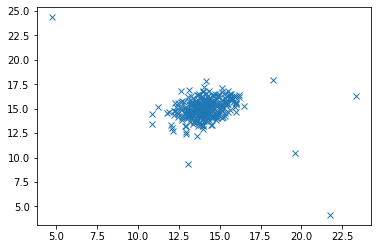

In [41]:
plt.plot(X[:,0], X[:,1], 'x')

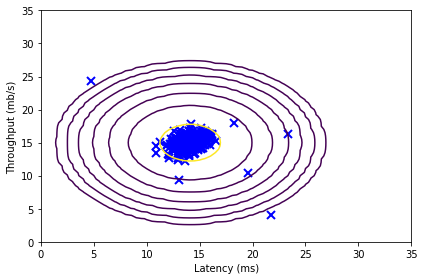

In [42]:
#  Estimate my and sigma2
mu, sigma2 = estimateGaussian(X)

#  Returns the density of the multivariate normal at each data point (row) 
#  of X
p = multivariateGaussian(X, mu, sigma2)

#  Visualize the fit
visualizeFit(X,  mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.tight_layout()

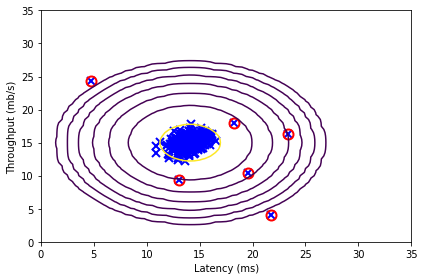

In [43]:
pval = multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)

#  Find the outliers in the training set and plot the
outliers = p < epsilon

#  Visualize the fit
visualizeFit(X,  mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.tight_layout()

#  Draw a red circle around those outliers
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', ms=10, mfc='None', mew=2)